# PyMMM: Python Mother Machine Manager

In [1]:
from Experiment.experiment import Experiment

The first thing to do is to define your experiment's directory, and instantite an `Experiment` object using that directory.
Let's also print the experiment's properties

In [2]:
a = "MI13_exit_dyn_2_A01_T001_Green.tif"

In [3]:
def custom_filename_splitter(filename):
    FOV = filename.split("_")[4]
    time = filename.split("_")[5]
    channel = filename.split("_")[6].split(".")[0]
    file_extension = filename.split("_")[-1].split(".")[-1]
    return FOV, time, channel, file_extension

In [4]:
def custom_img_path_generator(directory, FOV, channel, time, file_extension):
    return f"{directory}/MI13_exit_dyn_2_{FOV}_{time}_{channel}.{file_extension}" 

In [5]:
directory = '/home/georgeos/Dropbox (Cambridge University)/Nikon Nd2 Backup_Bakshi-Lab/gh464/MI13TnaAGFP_exit_dyn_2/'
my_experiment = Experiment(directory, custom_filename_splitter=custom_filename_splitter, custom_img_path_generator=custom_img_path_generator, save_filetype="png")
print(my_experiment)


            Experiment name: MI13TnaAGFP_exit_dyn_2
            Channels: ['Green', 'PC']
            Timepoints: 111
            FOVs: 80
            Registered: True
        


In [6]:
my_experiment.img_path_generator(my_experiment.extracted_dir, my_experiment.FOVs[0], my_experiment.channels[0], my_experiment.times[0], my_experiment.file_extension)

'/home/georgeos/Dropbox (Cambridge University)/Nikon Nd2 Backup_Bakshi-Lab/gh464/MI13TnaAGFP_exit_dyn_2//extracted//MI13_exit_dyn_2_A01_T001_Green.tif'

In [7]:
my_experiment.set_analysis_times(0, 50)

### Let's now ensure the quality of the data

We're going to register the images to minimise the effects of stage drift.

* First we will set the experiment's registration channel, here we are using `"PC"` for phase contrast.

In [8]:
my_experiment.registration_channel = "PC"

Next we will do two things:
* The first is to calculate mean images for the experiment. These are average images which will be used for image registration
* By default, PyMMM takes an average over the last 15 images of the experiment, as the experiment's stage drift has likely stopped by then.
* We can also rotate the mean image if the experiment was not properly aligned. This will rotate the mean images, and all other images will be registered against them, rotating them in the process.
* Let's just check our experiment without the rotation argument.

Mean images for 80 FOVs with rotation of 0 deg calculated, use the mean_images method to return a dict of mean images


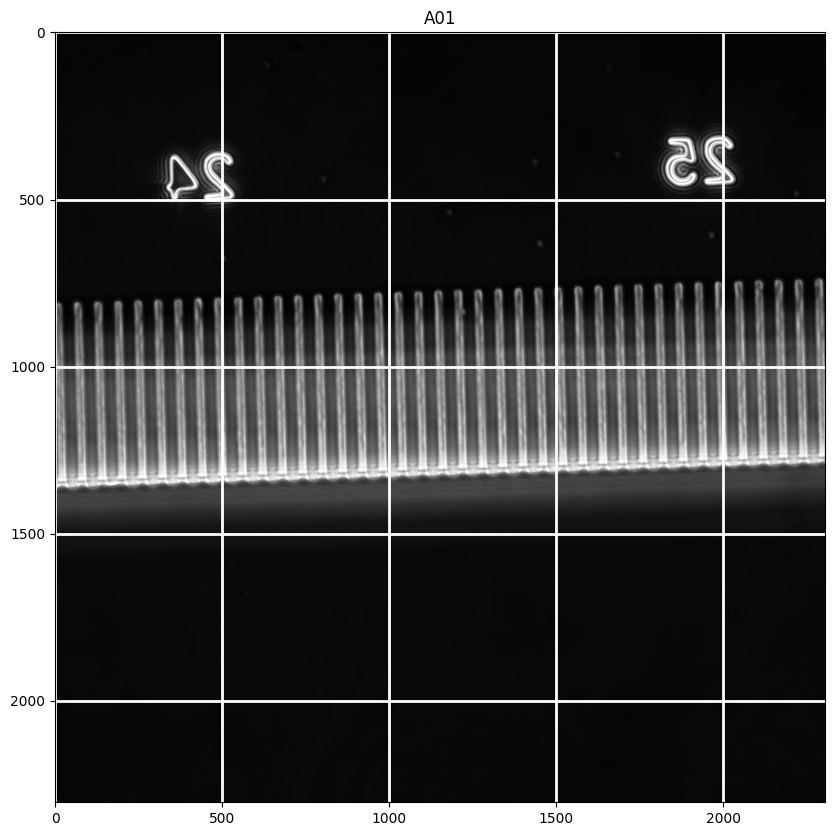

In [9]:
my_experiment.get_mean_images(plot = True)

It looks like there's some rotation in our experiment. Let's rotate the images and recalculate the mean images.

Mean images for 80 FOVs with rotation of -1.3 deg calculated, use the mean_images method to return a dict of mean images


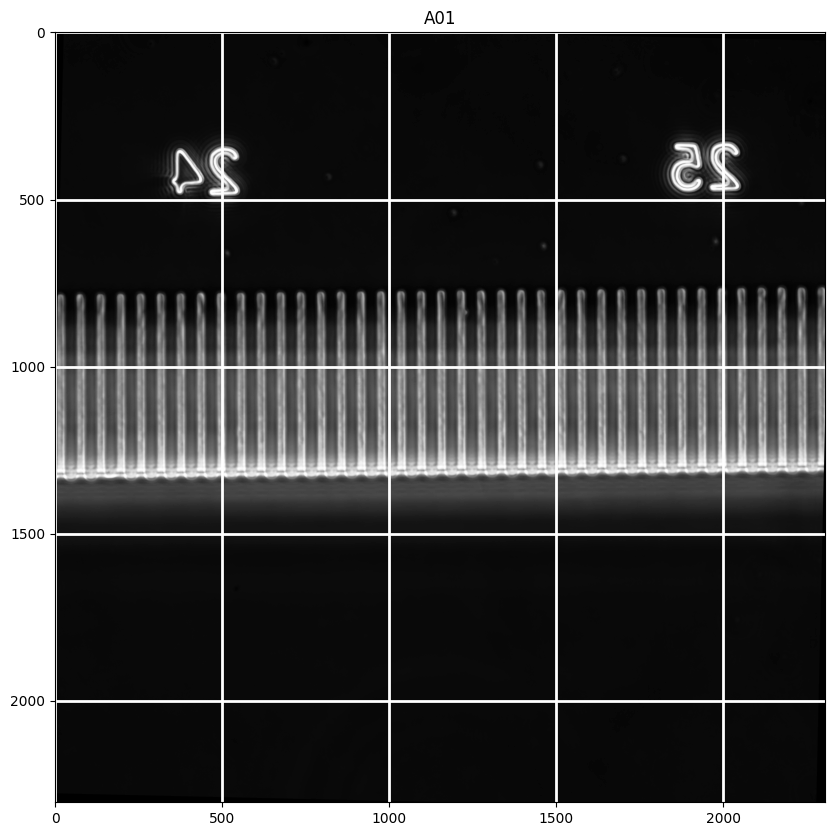

In [10]:
my_experiment.get_mean_images(rotation = -1.3, plot = True)

That's looking much better.
* We can now register the images. We only need to do this once, so we can check whether the experiment has already been registered with the `is_registered` property.
* Here we check if an experiment is registered, and not, we register it with all of our CPU cores.
* There is also a `force` argument, which if set to `True` will overwrite any previous registered images.

In [12]:
if not my_experiment.is_registered:
    my_experiment.register_experiment(force=False, mode="mean", sum=False, n_jobs = -1)

### Let's now find the trenches

There are several methods you can use to explore the experiment:

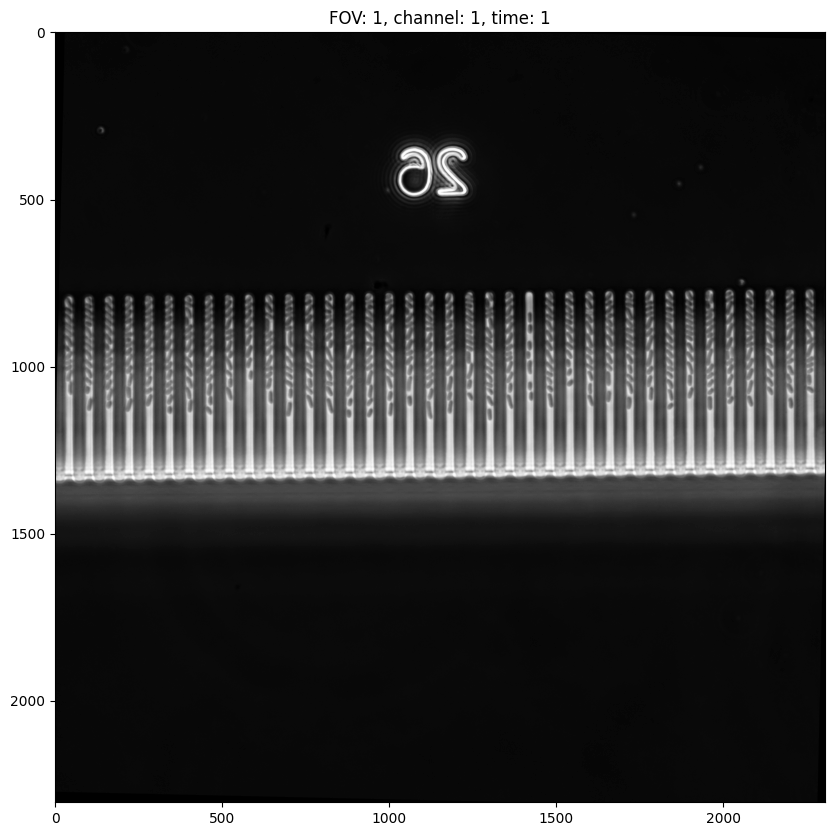

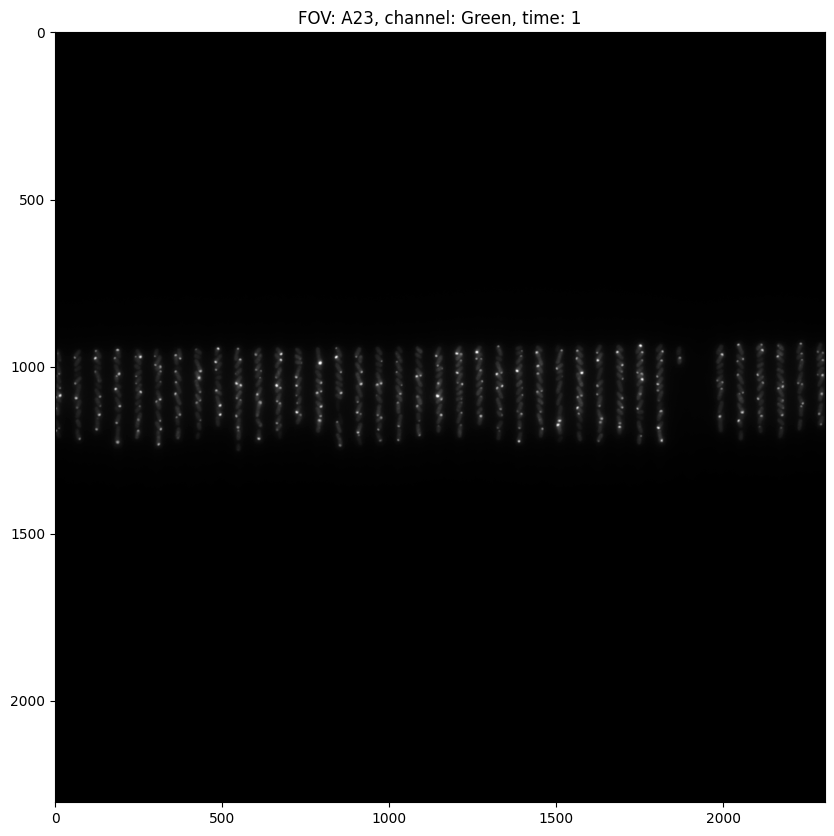

In [16]:
#Indexing using numbers
an_image = my_experiment.get_image(FOV = 1, channel = 1, time = 1, plot = True, registered = True)
#Indexing using channel and FOV names
an_image = my_experiment.get_image(FOV = "A23", channel = "Green", time = 1, plot = True, registered = True)

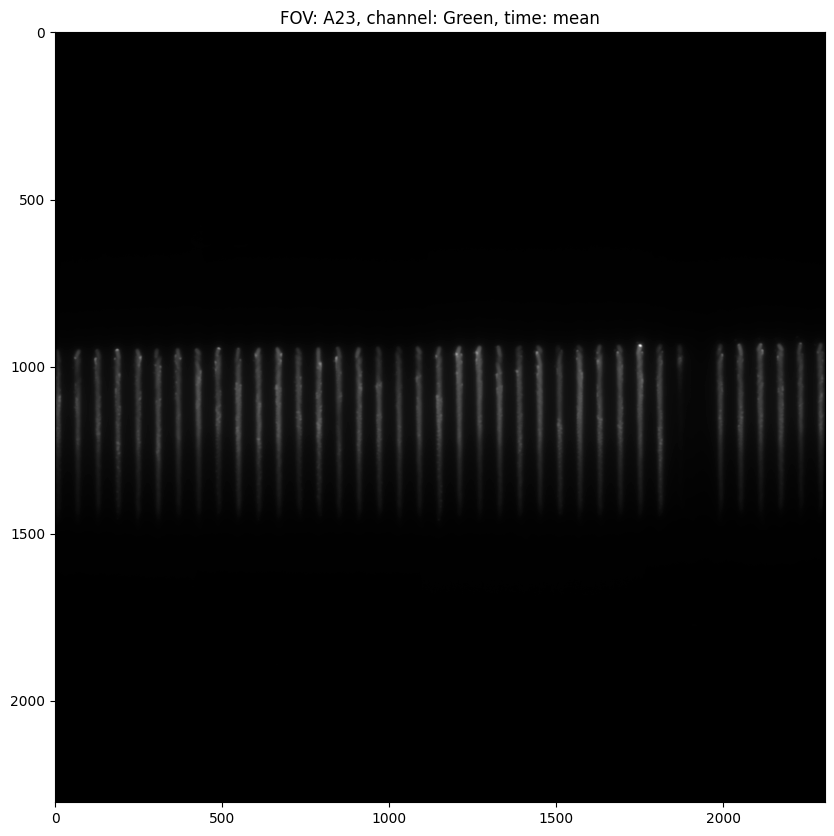

In [18]:
#Getting the mean of a timestack for a particular FOV
a_mean_image = my_experiment.get_mean_of_timestack("A23", "Green", plot=True)

In [19]:
mean_timestacks = [my_experiment.get_mean_of_timestack(FOV, "PC", ) for FOV in my_experiment.FOVs]

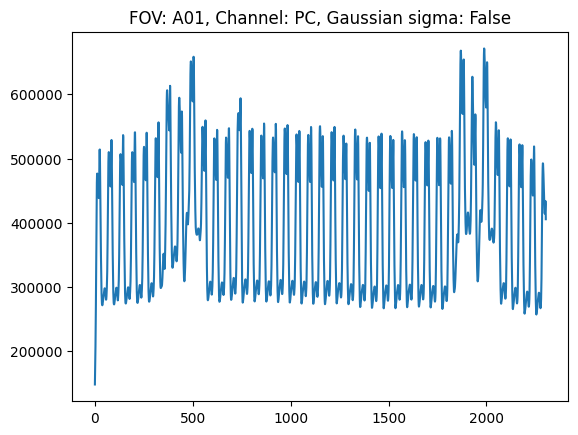

In [31]:
#Geting the mean of the timestack over the x direction
a_t_x_mean = my_experiment.mean_t_x("A01", my_experiment.registration_channel, plot = True)

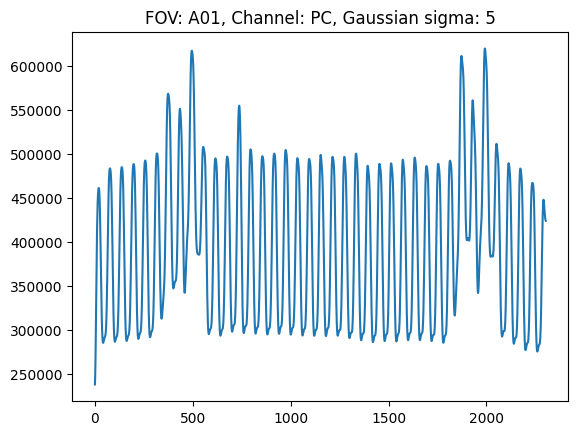

In [32]:
#Adding a gaussian blurring using the sigma argument
sigma = 5
a_t_x_mean = my_experiment.mean_t_x("A01", my_experiment.registration_channel, sigma = sigma, plot = True)

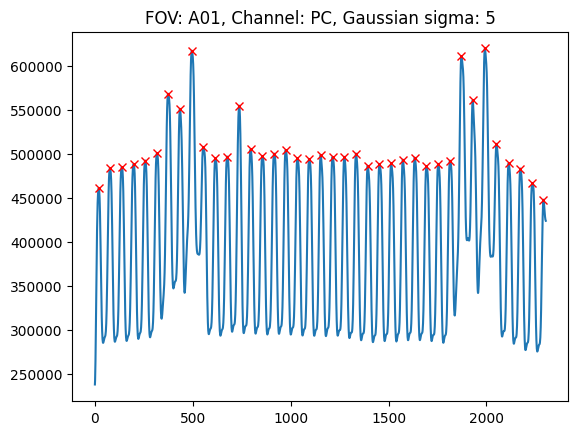

In [33]:
# Now finding trench peaks for a particular FOV, giving a distance argument, and using our sigma value from before
distance = 50
peaks = my_experiment.find_trench_peaks("A01", my_experiment.registration_channel, sigma = sigma, distance = distance, plot = True)

We've found good values for `sigma` and `distance`.
Let's now call `find_all_trench_x_positions` on the phase contrast channel to identify all the x limits of the trenches in every FOV

In [34]:
trench_x_positions = my_experiment.find_all_trench_x_positions(my_experiment.registration_channel, sigma = sigma, distance = distance, plot = False, plot_save=True)

So we've successfully found the x limits of the trenches. Let's now find the y limits

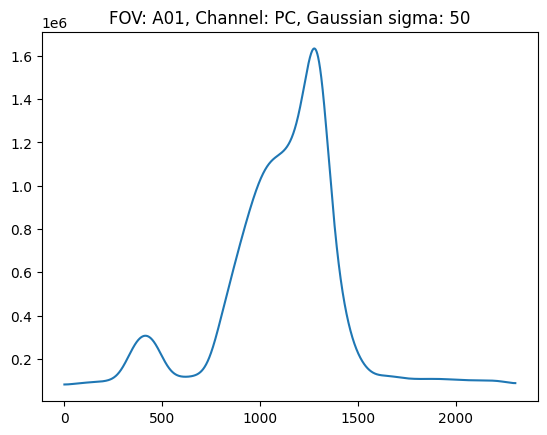

In [70]:
#Adding a gaussian blurring using the sigma argument
sigma = 50
a_t_y_mean = my_experiment.mean_t_y("A01", my_experiment.registration_channel, sigma = sigma, plot = True)

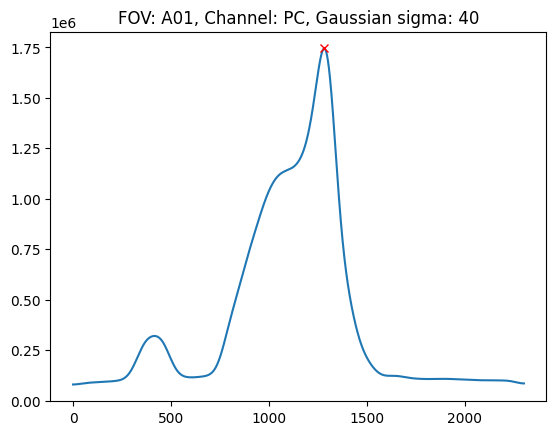

In [71]:
#Adding a gaussian blurring using the sigma argument
sigma = 40
height = 600000
distance = 1000
a_t_y_mean, y_peak = my_experiment.find_lane_peaks("A01", sigma = sigma, distance = distance, height=height, plot = True)

In [72]:
y_peaks = {FOV: my_experiment.find_lane_peaks(FOV, sigma=sigma, distance=distance, height=height, plot=False)[1] for FOV in my_experiment.FOVs}

In [73]:
my_experiment.trench_y_offsets = (530, 130)

In [67]:
a_mean_image = my_experiment.get_mean_of_timestack("A70", "PC", plot=False)

In [68]:
cropped = a_mean_image[y_peaks["A01"][0]-my_experiment.trench_y_offsets[0] : y_peaks["A01"][0]-my_experiment.trench_y_offsets[1]]

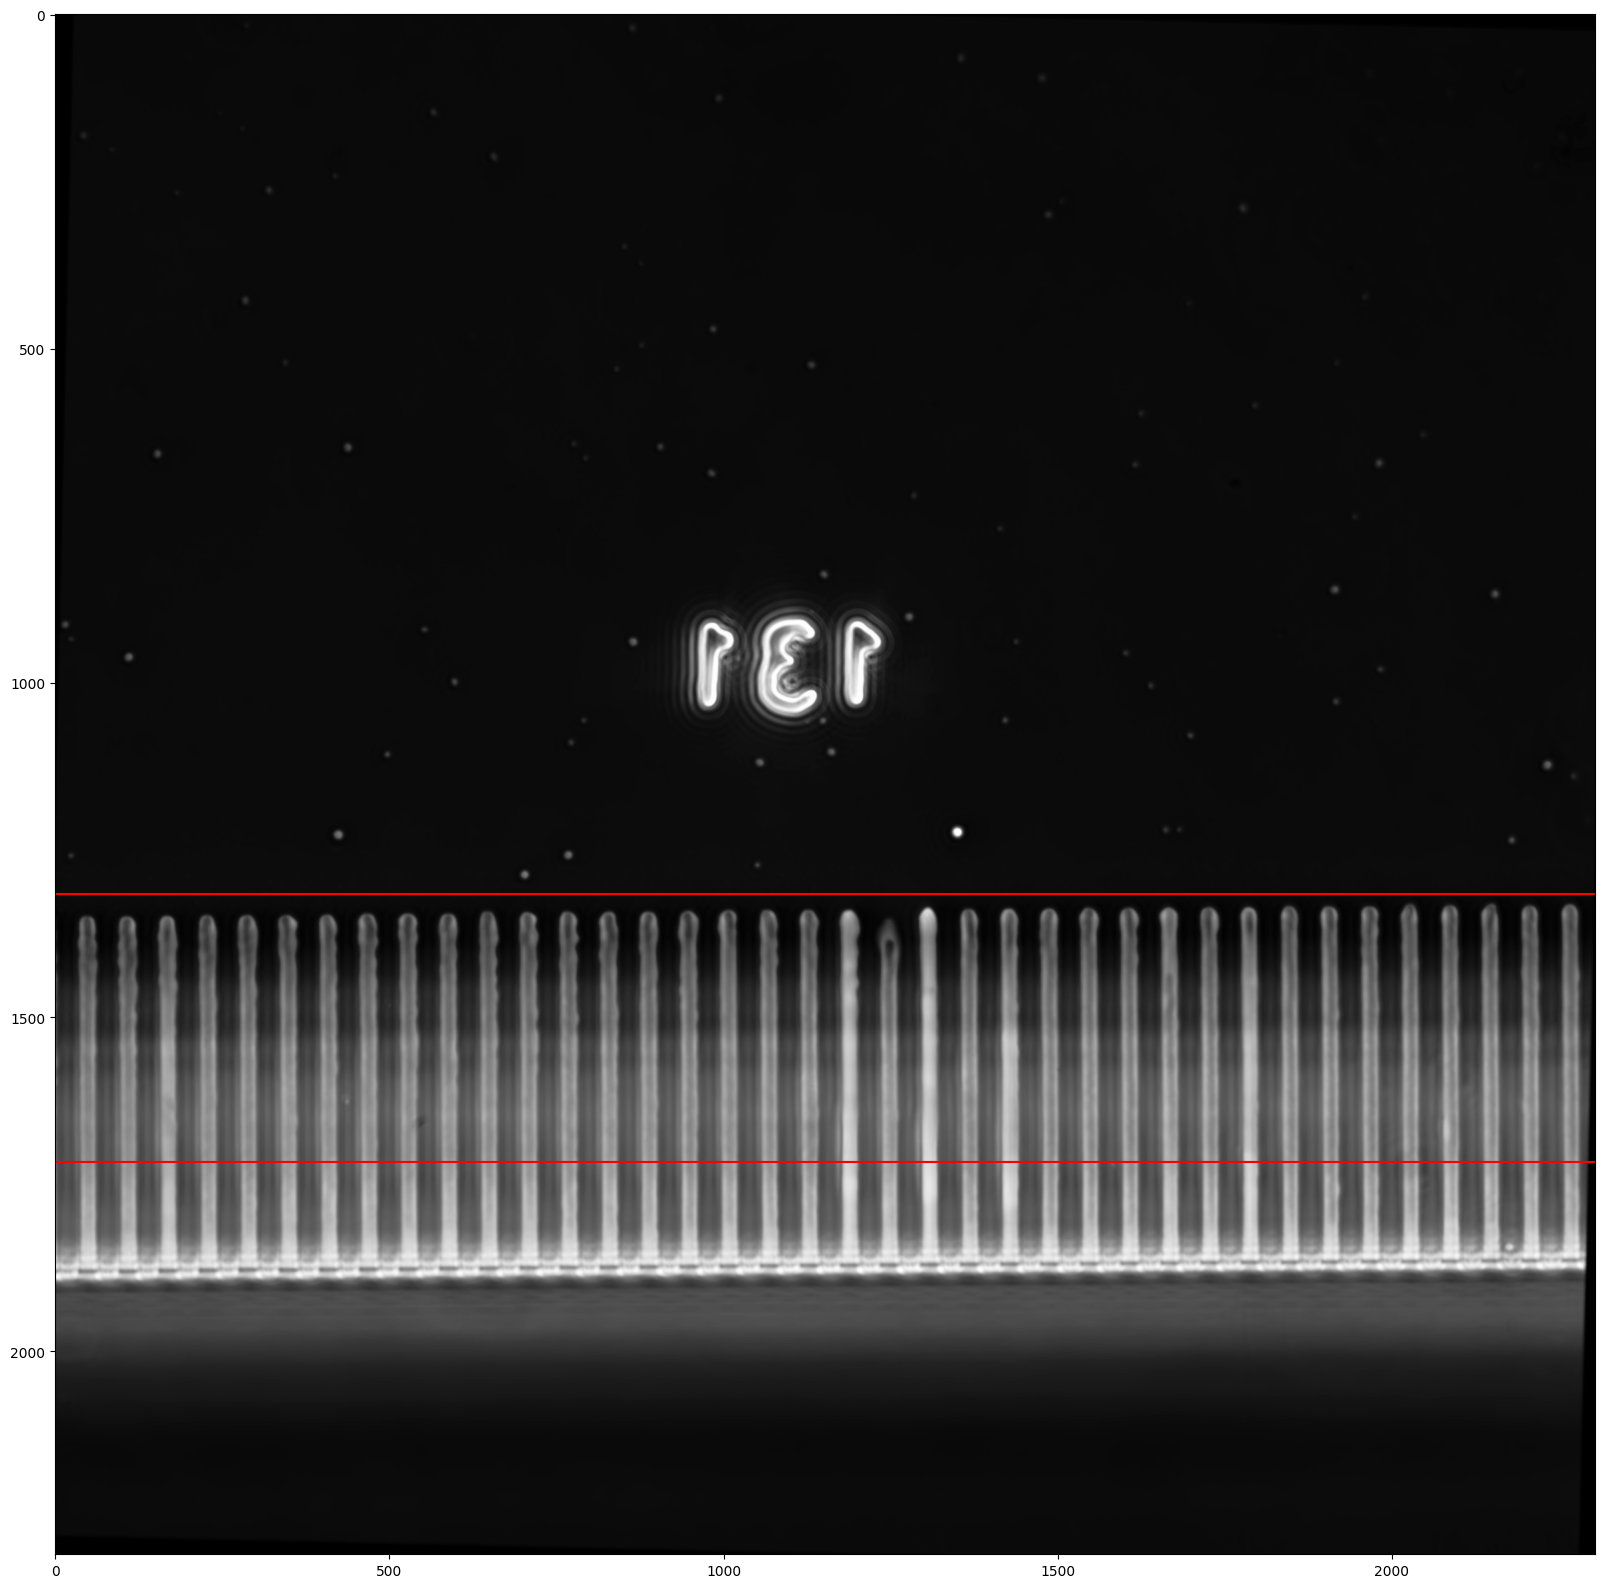

In [74]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plt.axhline(y_peaks["A70"][0]-my_experiment.trench_y_offsets[0], color="r")
plt.axhline(y_peaks["A70"][0]-my_experiment.trench_y_offsets[1], color="r")
plt.imshow(a_mean_image,cmap="Greys_r")

In [75]:
y_peaks = my_experiment.find_all_trench_y_positions_PC(channel=my_experiment.PC_channel,sigma=sigma,distance=distance,height=height,plot=False, plot_save=True)

In [76]:
my_experiment.extract_trenches(force=True)